This notebook wants to convince you that ''**ordered segmentation of vascular structures**'' is a good idea. What is ordered segmentation? You have your vessels, compute the skeleton out of them, and categorize each pixel as belonging to the bakground (B), the skeleton (S) or elsewhere (E). Elsewhere are then pixels that are on the vessel but not on the skeleton. This naturally gives rise to an order in the labels as (B=0, E=1, S=2). The idea is to avoid penalizing mistakes randomly, but rather penalizing, e.g., more a model when it predicts B and the pixel belongs to S, and less if it belongs to E. 

The working hypothesis here is as follows: clDice is mostly sensitive to mistakes in the skeleton, DSC (dice) is insensitive to mistakes being made in the skeleton or elsewhere, and we want something in between. Why? Because we may not have time or computing budget to train one model for segmenting properly the topology and another for segmenting properly the whole thing. We may want to measure quality of segmentations as a whole, but with an eye on topology-preservation. 

Reminder: cl-DSC is the average of two components, recall (get all ground-truth skeleton pixels segmented in your prediction, cares for False Negatives) and sensitivity (do not create new skeleton pixels in your prediction, cares for False Positives).

Spoiler: once we get the quality metric working, we will work on loss functions to improve it (I know how).

So far so good, let us see a visual example.

In [1]:
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import skimage.io as io
from skimage import img_as_ubyte
from skimage.morphology import skeletonize, dilation
from skimage.util import random_noise
from cldice import clDice, cl_score
from utils.metric_factory import fast_bin_dice

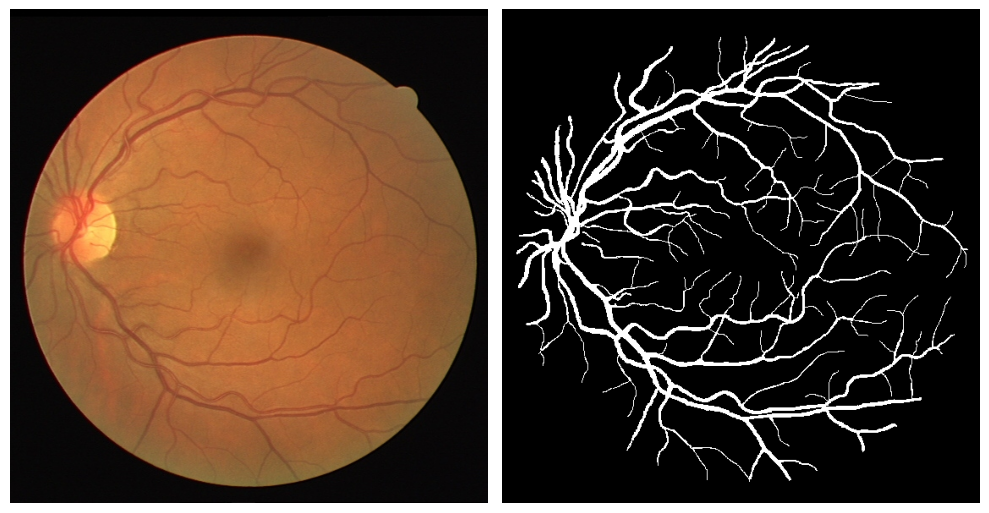

In [2]:
# the most boring retinal image ever
path_im = 'data/DRIVE/images/01_test.tif'
path_mask = 'data/DRIVE/manual/01_manual1.gif'

img = io.imread(path_im)
gt = io.imread(path_mask)[0]

f, a = plt.subplots(ncols=2, figsize=(10,10))
a[0].imshow(img)
a[1].imshow(gt, cmap='gray')
for ax in a: ax.axis('off')
plt.tight_layout()

Let us have a look at its skeleton:

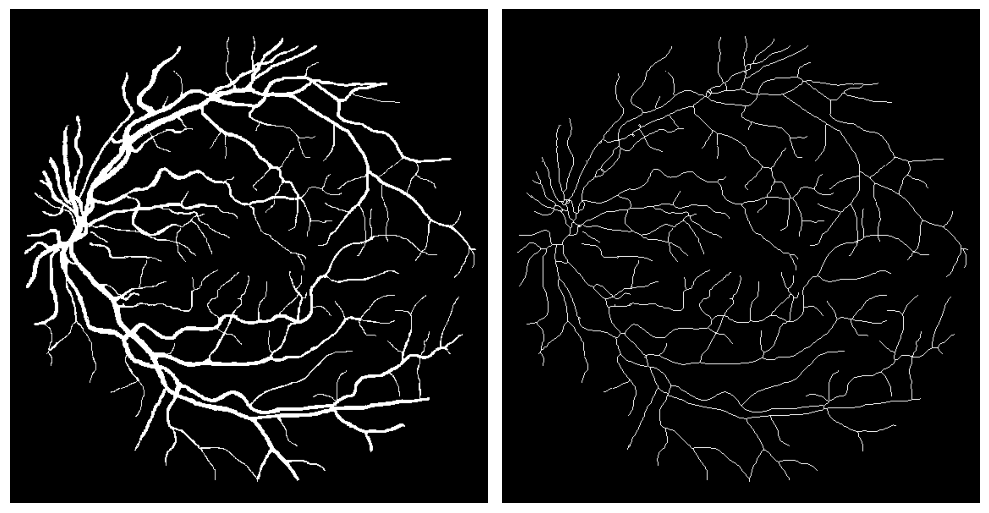

In [3]:
label = gt>0
skel = skeletonize(label)
f, a = plt.subplots(ncols=2, figsize=(10,10))
a[0].imshow(label, cmap='gray')
a[1].imshow(skel, cmap='gray')
for ax in a.flatten(): ax.axis('off')
plt.tight_layout()

What happens if we compute DSC and cl-DSC between the labels and their skeleton? We would expect that the clDice remains perfect, but the DSC gets a hit:

'DSC=48.06, cl-DSC=100.00'

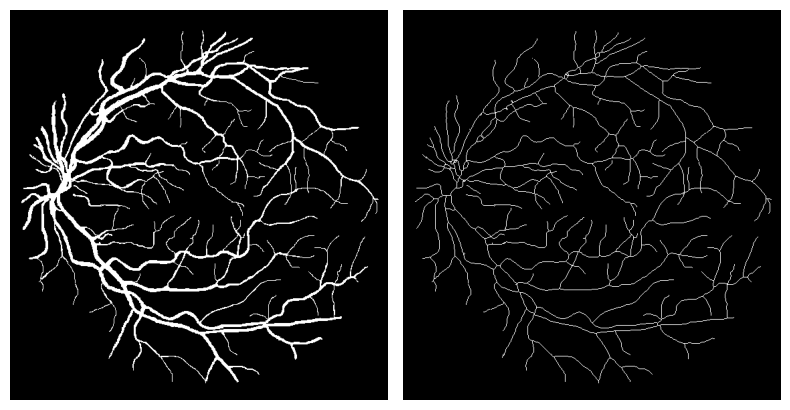

In [4]:
pred=skel

f, a = plt.subplots(ncols=2, figsize=(8,8))
a[0].imshow(label, cmap='gray')
a[1].imshow(pred, cmap='gray')
for ax in a.flatten(): ax.axis('off')
plt.tight_layout()

dsc_score = fast_bin_dice(label, pred)
cldice = clDice(pred, label)
'DSC={:.2f}, cl-DSC={:.2f}'.format(100*dsc_score,100*cldice)

And what happens if we dilate the labels? Since the skeleton of the labels and the skeleton of their dilation is almost the same, we again would expect clDice to stay high, but see a decrease in the DSC:

'DSC=76.91, cl-DSC=97.51'

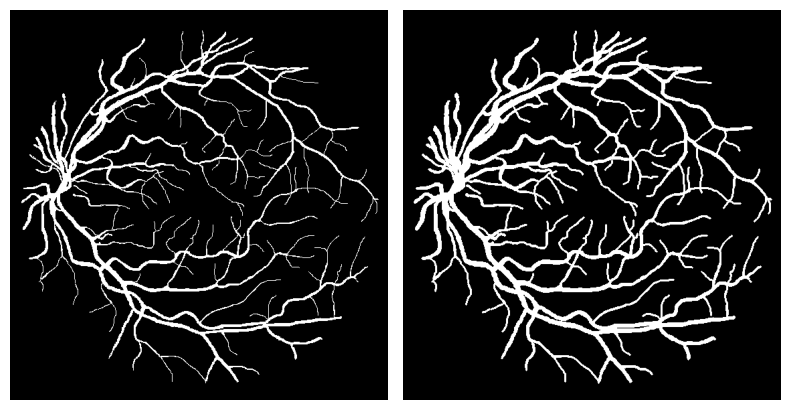

In [5]:
pred=dilation(label)

f, a = plt.subplots(ncols=2, figsize=(8,8))
a[0].imshow(label, cmap='gray')
a[1].imshow(pred, cmap='gray')
for ax in a.flatten(): ax.axis('off')
plt.tight_layout()

# if we dilate we lose 25% of dsc but 2.5% of cl-DSC
dsc_score = fast_bin_dice(label, pred)
cldice = clDice(pred, label)
'DSC={:.2f}, cl-DSC={:.2f}'.format(100*dsc_score,100*cldice)

Now we will add salt noise to the segmentation (create some FP). We expect the clDICE to be severely affected, because we are creating new skeletons everywhere! The dice score will also suffer, but much less in theory, as it cares a lot about overlap, and we are not significantly degrading it.

'DSC=92.03, cl-DSC=79.70'

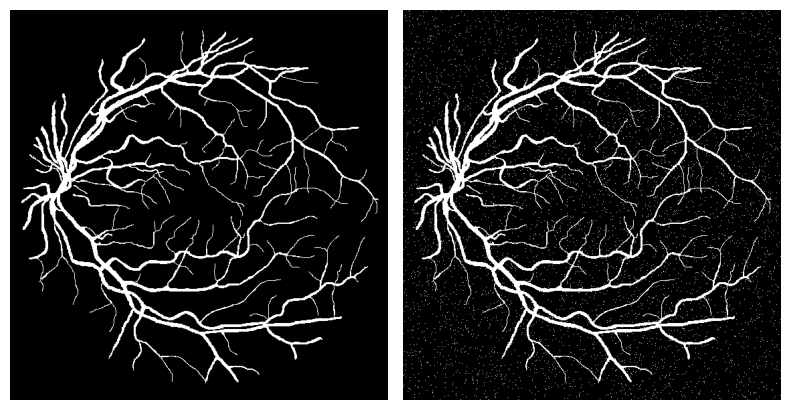

In [6]:
#pred = random_noise(label, mode='s&p', amount=0.035).astype(bool)
pred = random_noise(label, mode='salt', amount=0.017).astype(bool)

f, a = plt.subplots(ncols=2, figsize=(8,8))
a[0].imshow(label, cmap='gray')
a[1].imshow(pred, cmap='gray')
for ax in a.flatten(): ax.axis('off')
plt.tight_layout()

# if we add noise we lose 20% of cldsc but only 10% of cl-DSC
dsc_score = fast_bin_dice(label, pred)
cldice = clDice(pred, label)
'DSC={:.2f}, cl-DSC={:.2f}'.format(100*dsc_score,100*cldice)

By the way, if we add pepper noise (create FN), we won't see much of a difference, because most of the created black pixels were already black. In any case, as a curiosity, the DSC and the clDSC are equally affected by this process, need to analyze this later.

'DSC=97.44, cl-DSC=97.37'

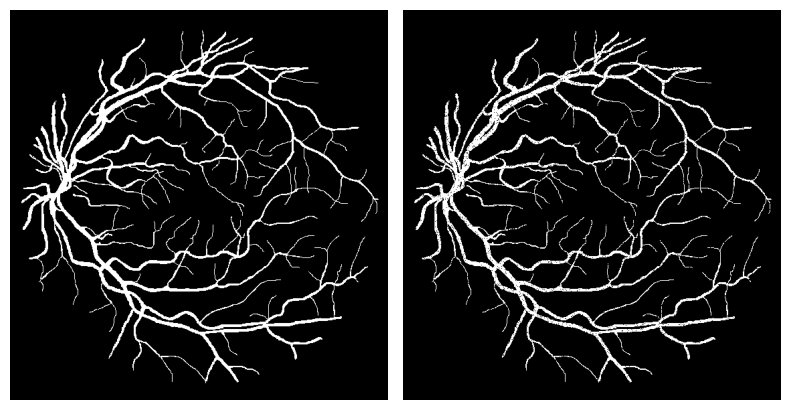

In [7]:
#pred = random_noise(label, mode='s&p', amount=0.035).astype(bool)
pred = random_noise(label, mode='pepper', amount=0.05).astype(bool)

f, a = plt.subplots(ncols=2, figsize=(8,8))
a[0].imshow(label, cmap='gray')
a[1].imshow(pred, cmap='gray')
for ax in a.flatten(): ax.axis('off')
plt.tight_layout()

# if we add noise we lose 20% of cldsc but only 10% of cl-DSC
dsc_score = fast_bin_dice(label, pred)
cldice = clDice(pred, label)
'DSC={:.2f}, cl-DSC={:.2f}'.format(100*dsc_score,100*cldice)

Let us implement the ordered segmentation idea. It's actually very straightforward:

In [8]:
skel = skeletonize(label)
new_gt = np.zeros_like(label, dtype=np.uint8)
new_gt[label]=1
new_gt[skel]=2
np.unique(new_gt)

array([0, 1, 2], dtype=uint8)

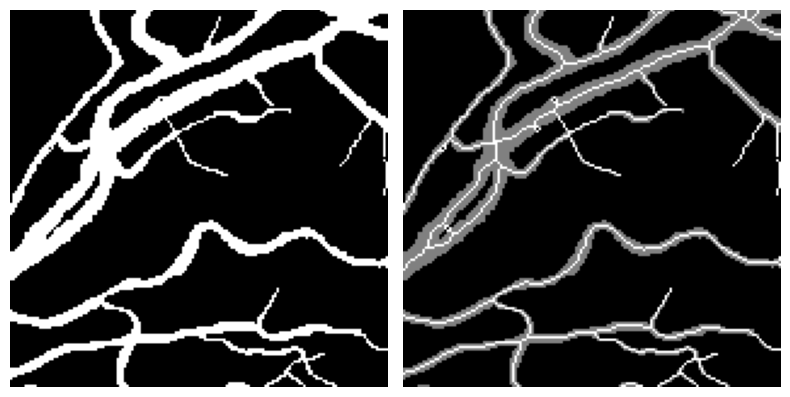

In [9]:
f, a = plt.subplots(ncols=2, figsize=(8,8))
a[0].imshow(label[100:256,100:256], cmap='gray')
a[1].imshow(img_as_ubyte(new_gt)[100:256,100:256], cmap='gray')
for ax in a.flatten(): ax.axis('off')
plt.tight_layout()

Let us package that process in a function for convenience:

In [10]:
def get_ordinal_format(bin_seg):
    assert bin_seg.dtype==bool
    skel = skeletonize(bin_seg)
    ordered_seg = np.zeros_like(bin_seg, dtype=np.uint8)
    ordered_seg[bin_seg]=1
    ordered_seg[skel]=2
    return ordered_seg

In order to measure performance of ordinal classifiers, we typically use the quardatically-weighted kappa score, see:

In [11]:
from sklearn.metrics import cohen_kappa_score as kappa

l, p1, p2 = [0,0,1,1,2], [0,0,1,1,0], [0,0,1,1,1] # p1 is worse than p2 because 0 is worse than 1 when the label was 2
kappa(l, p1, weights='quadratic'), kappa(l, p2, weights='quadratic')

(0.16666666666666674, 0.7619047619047619)

We can again encapsulate the quad-kappa for ordered segmentation into a function below:

In [12]:
def ordered_topology_metric(bin_seg, bin_pred):
    assert bin_seg.dtype==bool
    assert bin_pred.dtype==bool
    ordered_seg = get_ordinal_format(bin_seg)
    ordered_pred = get_ordinal_format(bin_pred)
    score = kappa(ordered_seg.flatten(), ordered_pred.flatten(), weights='quadratic')
    return score

Let us now go again over the previous examples and see if this metric captures all those failure modes:

'DSC=76.91, cl-DSC=97.51, OTM=81.27'

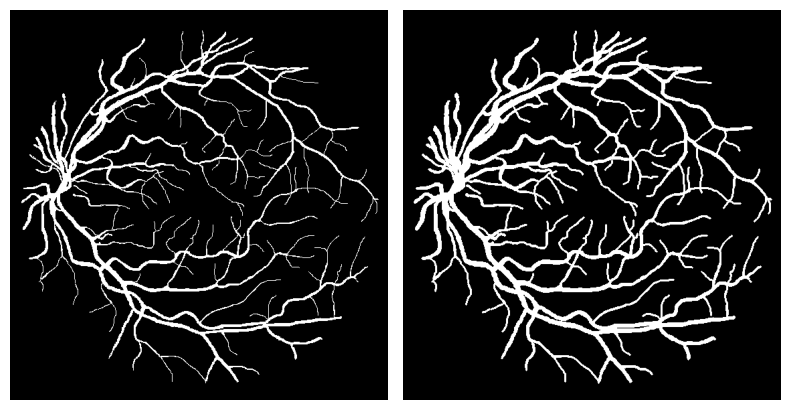

In [13]:
pred=dilation(label)

f, a = plt.subplots(ncols=2, figsize=(8,8))
a[0].imshow(label, cmap='gray')
a[1].imshow(pred, cmap='gray')
for ax in a.flatten(): ax.axis('off')
plt.tight_layout()

# if we dilate we lose 25% of dsc but 2.5% of cl-DSC
dsc_score = fast_bin_dice(label, pred)
cldice = clDice(pred, label)
otm = ordered_topology_metric(label, pred)
'DSC={:.2f}, cl-DSC={:.2f}, OTM={:.2f}'.format(100*dsc_score,100*cldice,100*otm)

'DSC=92.02, cl-DSC=79.70, OTM=83.72'

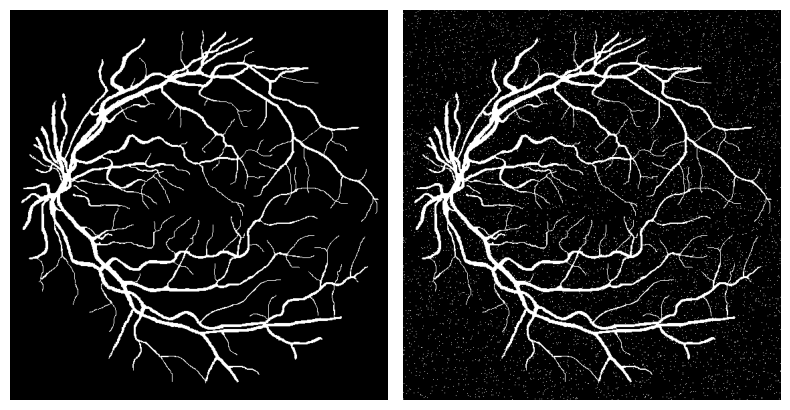

In [14]:
#pred = random_noise(label, mode='s&p', amount=0.035).astype(bool)
pred = random_noise(label, mode='salt', amount=0.017).astype(bool)

f, a = plt.subplots(ncols=2, figsize=(8,8))
a[0].imshow(label, cmap='gray')
a[1].imshow(pred, cmap='gray')
for ax in a.flatten(): ax.axis('off')
plt.tight_layout()

# if we add noise we lose 20% of cldsc but only 10% of cl-DSC
dsc_score = fast_bin_dice(label, pred)
cldice = clDice(pred, label)
otm = ordered_topology_metric(label, pred)
'DSC={:.2f}, cl-DSC={:.2f}, OTM={:.2f}'.format(100*dsc_score,100*cldice,100*otm)

Looking good, this OTM thing appears to be sensitive to **both** overlap and topological correctness. 

Lets work out another example. Suppose you get a lesion segmented as vessel, so you create a false positive. Let us simulate that with a circle on the top left corner, with a radius of 5. Pay attention to the figure titles, where I am printing the metric values:

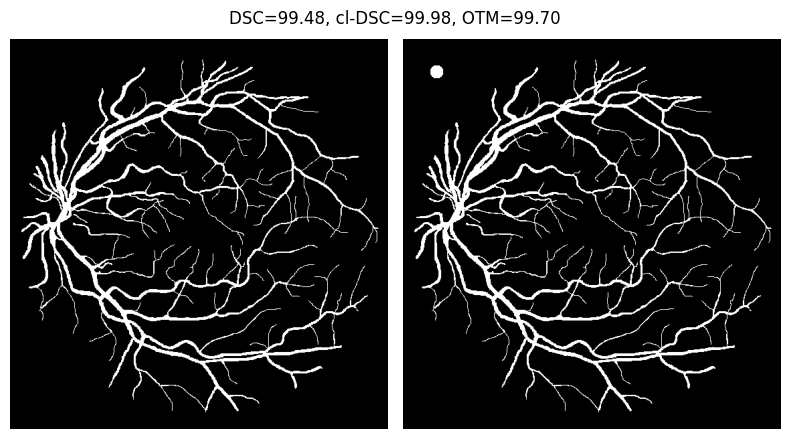

In [15]:
from skimage.draw import disk

radius = 10
pred = label.copy()
rr, cc = disk((50, 50), radius)
pred[rr, cc] = 1


f, a = plt.subplots(ncols=2, figsize=(8,8))
a[0].imshow(label, cmap='gray')
a[1].imshow(pred, cmap='gray')
for ax in a.flatten(): ax.axis('off')
f.tight_layout()

dsc_score = fast_bin_dice(label, pred)
cldice = clDice(pred, label)
otm = ordered_topology_metric(label, pred)

plt.suptitle('DSC={:.2f}, cl-DSC={:.2f}, OTM={:.2f}'.format(100*dsc_score,100*cldice,100*otm), y=0.78);

It's funny that metrics do not care a lot about that horrible white spot of a considerable size. 

Anyway, we are now going to create now increasingly larger lesions, and we expect that, as we increase the size of that thing, the DSC will go down, while the clDSC will not care, because we are only creating one False Positive, if we think "skeleton-wise". Let us see what happens:

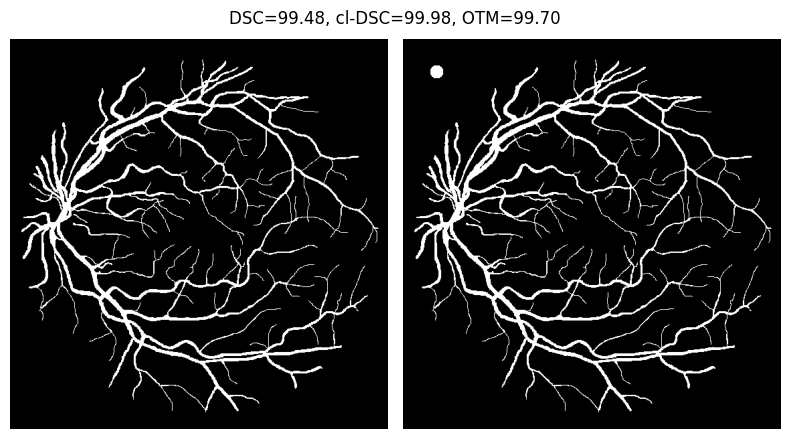

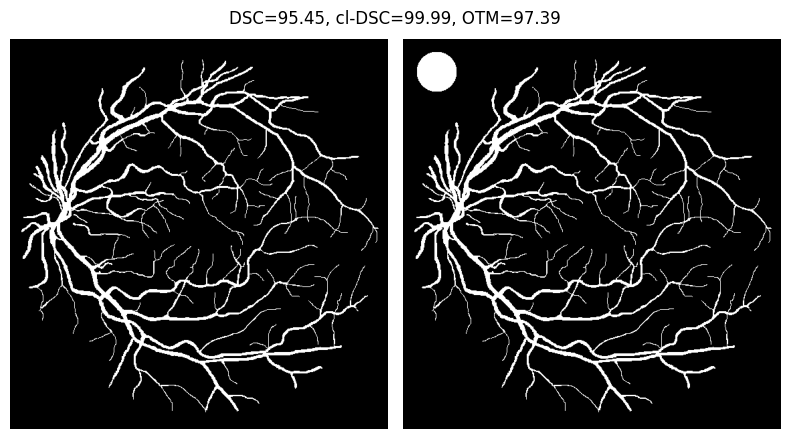

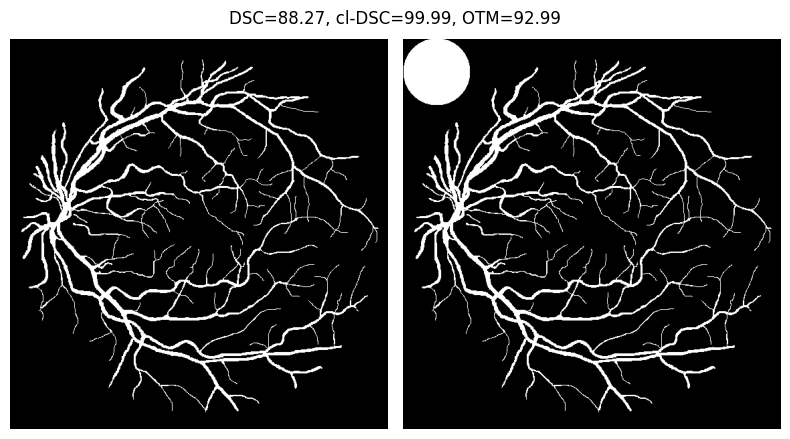

In [91]:
for radius in [10,30,50,]:
    pred = label.copy()
    rr, cc = disk((50, 50), radius)
    pred[rr, cc] = 1
    
    f, a = plt.subplots(ncols=2, figsize=(8,8))
    a[0].imshow(label, cmap='gray')
    a[1].imshow(pred, cmap='gray')
    for ax in a.flatten(): ax.axis('off')
    f.tight_layout()
    
    dsc_score = fast_bin_dice(label, pred)
    cldice = clDice(pred, label)
    otm = ordered_topology_metric(label, pred)
    
    plt.suptitle('DSC={:.2f}, cl-DSC={:.2f}, OTM={:.2f}'.format(100*dsc_score,100*cldice,100*otm), y=0.78);

Just for fun, we will add circles on other corners of the image and check the results:

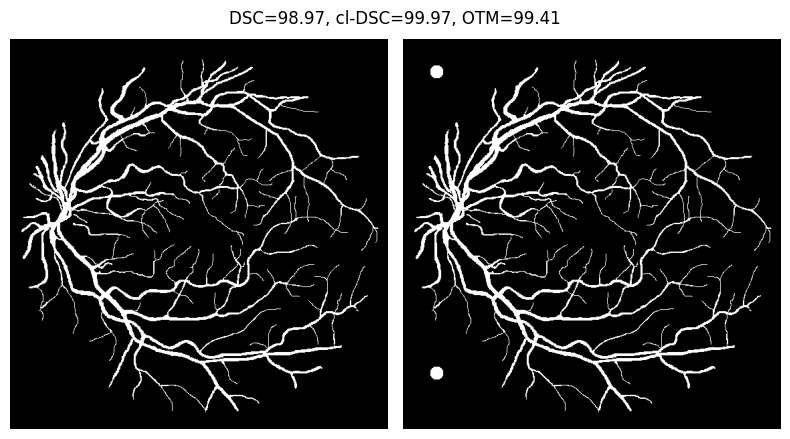

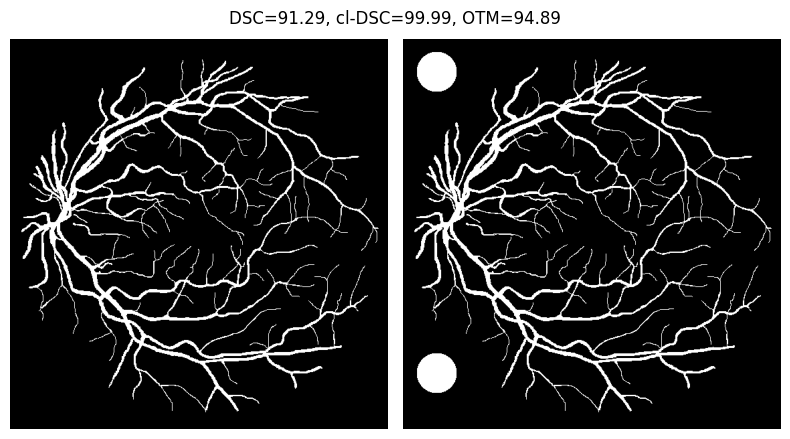

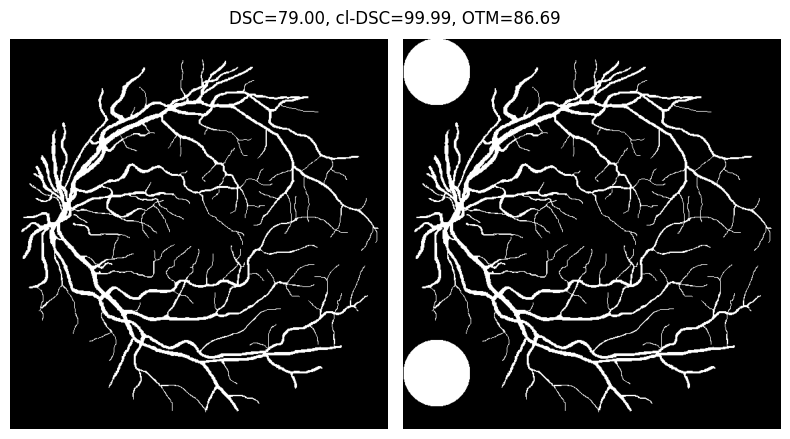

In [92]:
for radius in [10,30,50,]:
    pred = label.copy()
    rr, cc = disk((50, 50), radius)
    pred[rr, cc] = 1
    rr, cc = disk((500, 50), radius)
    pred[rr, cc] = 1
    
    f, a = plt.subplots(ncols=2, figsize=(8,8))
    a[0].imshow(label, cmap='gray')
    a[1].imshow(pred, cmap='gray')
    for ax in a.flatten(): ax.axis('off')
    f.tight_layout()
    
    dsc_score = fast_bin_dice(label, pred)
    cldice = clDice(pred, label)
    otm = ordered_topology_metric(label, pred)
    
    plt.suptitle('DSC={:.2f}, cl-DSC={:.2f}, OTM={:.2f}'.format(100*dsc_score,100*cldice,100*otm), y=0.78);

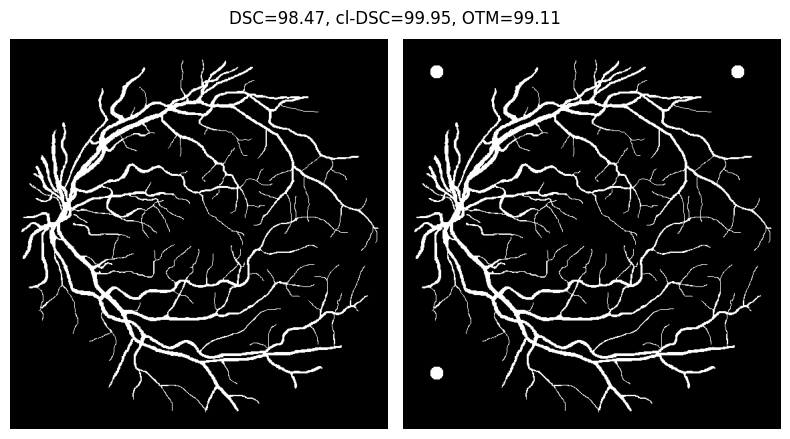

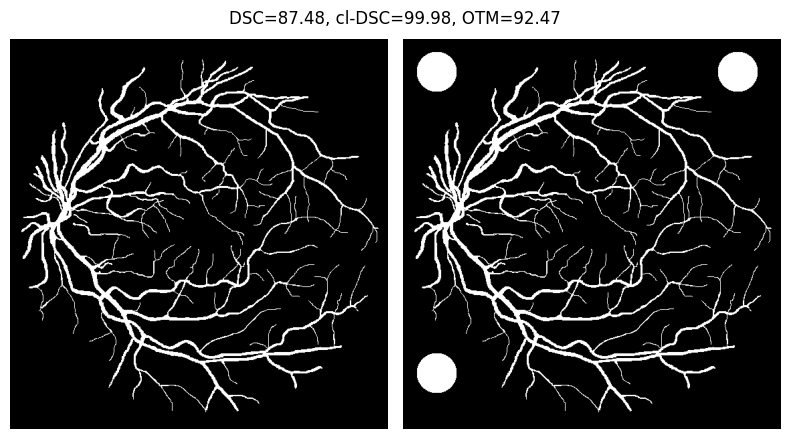

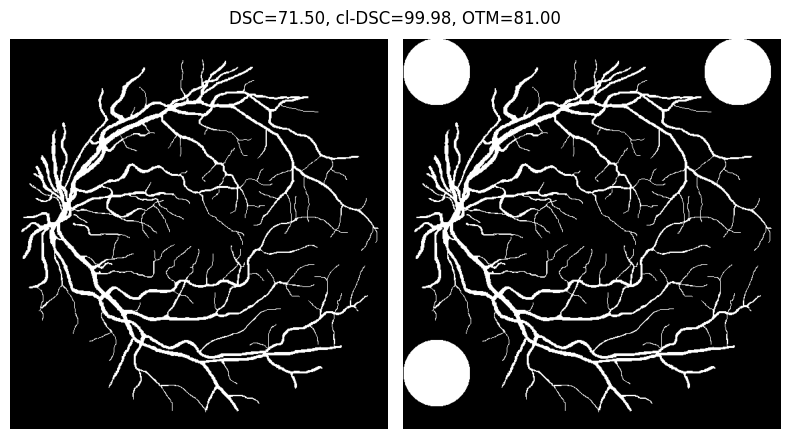

In [93]:
for radius in [10,30,50,]:
    pred = label.copy()
    rr, cc = disk((50, 50), radius)
    pred[rr, cc] = 1
    rr, cc = disk((500, 50), radius)
    pred[rr, cc] = 1
    rr, cc = disk((50, 500), radius)
    pred[rr, cc] = 1
    
    f, a = plt.subplots(ncols=2, figsize=(8,8))
    a[0].imshow(label, cmap='gray')
    a[1].imshow(pred, cmap='gray')
    for ax in a.flatten(): ax.axis('off')
    f.tight_layout()
    
    dsc_score = fast_bin_dice(label, pred)
    cldice = clDice(pred, label)
    otm = ordered_topology_metric(label, pred)
    
    plt.suptitle('DSC={:.2f}, cl-DSC={:.2f}, OTM={:.2f}'.format(100*dsc_score,100*cldice,100*otm), y=0.78);

So the clDICE is always perfect, the DSC goes down, and our OTM goes down, but not so dramatically. We are indeed building something in between clDice and DICE, yay! 

Next chapter will be to use some ordinal-classification loss functions to optimize a model and see if we get better performance, understanding performace as OTM. Some less toy-ish examples for the motivation would also be benefitial...